In [26]:
from icecube import dataclasses, icetray, dataio, clsim, dst
from icecube import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
import os
from datetime import datetime, timezone
import numpy as np
import json

### select day and device

In [27]:
day = '0110'
device = 'str88_dev78'

### load extracted data

In [29]:
save_path = os.path.join('/data/user/leidensc/upgrade_installation_ops/freeze_in/',day)
dev_dir = '/data/ana/Calibration/POCAM/data/freezein/device/'
dev_path = os.path.join(dev_dir,day)
time_file = 'run_start_end_emitter_start_end_'+device+'.json'
with open(os.path.join(dev_path,time_file), 'r') as file:
    time_stamps = json.load(file)

#### maybe needed

In [4]:
gcd_path = '/data/ana/Calibration/POCAM/data/freezein/detector/gcd_files'
gcd_file = 'PFGCD_Run00141840_Subrun00000000.i3.gz'
gcd_i3 = dataio.I3File(os.path.join(gcd_path,gcd_file))
geoframe = gcd_i3.pop_frame()
geoframe = gcd_i3.pop_frame()
geoframe = gcd_i3.pop_frame()

print(geoframe)

[ I3Frame  (DetectorStatus):
  'I3Calibration' [Calibration] ==> I3Calibration (36834005)
  'I3DetectorStatus' [DetectorStatus] ==> I3DetectorStatus (944399)
  'I3Geometry' [Geometry] ==> I3Geometry (619329)
]



In [5]:
for key in list(geoframe['I3DetectorStatus'].trigger_status.keys()):
    print(key)
status = (geoframe['I3DetectorStatus'])
print(status)

[IN_ICE:SIMPLE_MULTIPLICITY:1006]
[IN_ICE:SIMPLE_MULTIPLICITY:1011]
[IN_ICE:SIMPLE_MULTIPLICITY:30003]
[IN_ICE:SLOW_PARTICLE:24003]
[IN_ICE:FAINT_PARTICLE:33001]
[IN_ICE:STRING:1007]
[IN_ICE:VOLUME:21001]
[IN_ICE:UNBIASED:23050]
[ICE_TOP:SIMPLE_MULTIPLICITY:102]
[ICE_TOP:SIMPLE_MULTIPLICITY:30002]
[ICE_TOP:SIMPLE_MULTIPLICITY:30043]
[ICE_TOP:CALIBRATION:1009]
[ICE_TOP:MIN_BIAS:101]
[ICE_TOP:MIN_BIAS:210]
[ICE_TOP:VOLUME:21002]
[GLOBAL:THROUGHPUT]


In [30]:
log_start = datetime.strptime(time_stamps['first_log'], "%Y-%m-%d %H:%M:%S,%f").replace(tzinfo=timezone.utc)
log_end = datetime.strptime(time_stamps['end_log'], "%Y-%m-%d %H:%M:%S,%f").replace(tzinfo=timezone.utc)
run_start = datetime.strptime(time_stamps['run_start'], "%Y-%m-%d %H:%M:%S,%f").replace(tzinfo=timezone.utc)
run_end =  datetime.strptime(time_stamps['run_end'], "%Y-%m-%d %H:%M:%S,%f").replace(tzinfo=timezone.utc)

print(log_start)
print(log_end)

print(run_start)
print(run_end)

2026-01-10 20:28:29.841000+00:00
2026-01-10 20:29:50.022000+00:00
2026-01-10 20:28:19.812000+00:00
2026-01-10 20:29:59.825000+00:00


### load data

In [31]:
with open(os.path.join(save_path,device), 'r') as file:
    data_dict_all = json.load(file)

### time binning

In [32]:
data_dict = data_dict_all['80']

all_times = np.array([t for module_dict in data_dict.values() for t in module_dict.keys()])

index = [i for i, x in enumerate(all_times) if float(x) > 0]
ns_h_conv = 10**(9)

t_min = float(int((log_start - run_start).total_seconds()   * 1e9))/ns_h_conv
t_max = float(int((log_end - run_start).total_seconds()  * 1e9))/ns_h_conv


#BIN_WIDTH_NS = 0.001  # s # for looking into one side flash (master, slave, both)
BIN_WIDTH_NS = 0.2*10**9/ns_h_conv      # bin size for looking at the entire run
#BIN_WIDTH_NS = 0.01*10**9/ns_h_conv

time_edges = np.arange(t_min, t_max + BIN_WIDTH_NS, BIN_WIDTH_NS)
N_time_bins = len(time_edges) - 1
print(N_time_bins)

401


### space binning

In [24]:
space_list = list(data_dict.keys())
N_space = len(space_list)
space_vals = list(map(int, space_list))


intensity = np.zeros((N_space, N_time_bins))


for i, y in enumerate(space_list):
    for t_ns, charge in data_dict[y].items():
        j = int((float(t_ns)/ns_h_conv - t_min) // BIN_WIDTH_NS)
        if 0 <= j < N_time_bins:
            intensity[i, j] += charge

#intensity[intensity < 50] = np.nan


dy = np.diff(np.array(space_vals)).mean()
space_edges = np.concatenate(([space_vals[0] - dy/2], space_vals[:-1] + dy/2, [space_vals[-1] + dy/2]))

/tmp/ipykernel_1172/2697369628.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(ticklabs, fontsize=14)


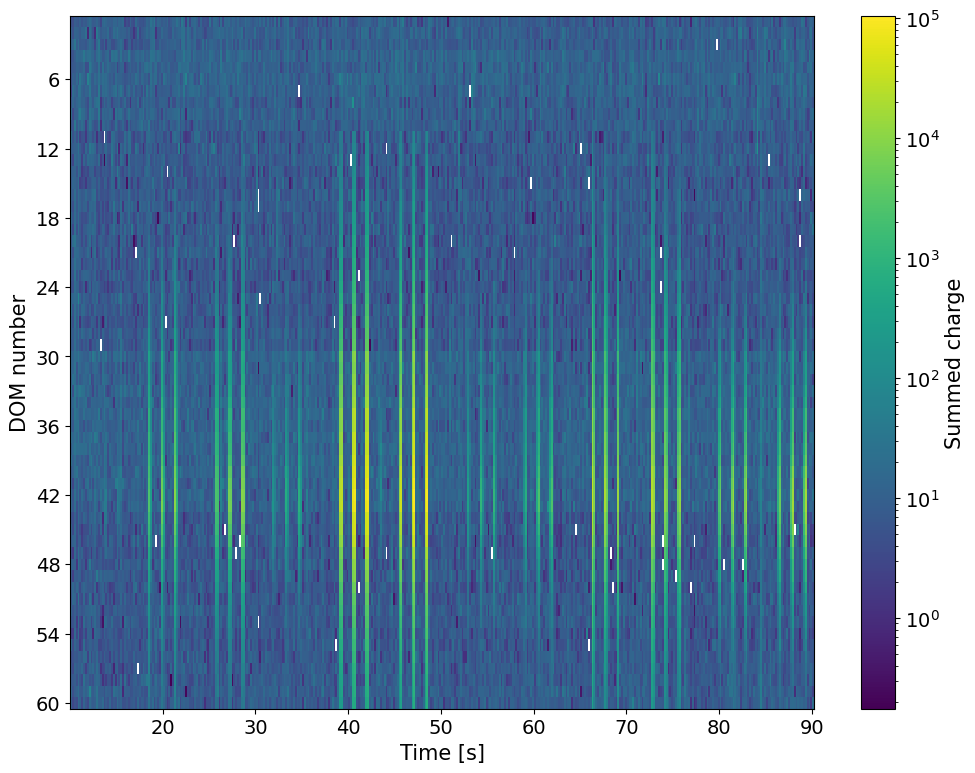

In [25]:
fig, ax = plt.subplots(figsize = (12,9), ncols = 1, nrows =1)
plt.pcolormesh(time_edges, space_edges, intensity, shading="flat", norm=LogNorm())
#plt.hlines(53, xmin = t_min, xmax = t_max, linestyles='dashed', color='red', alpha = 0.5, linewidth = 2)#, size = 0.5)
plt.gca().invert_yaxis()
plt.xlabel("Time [s]", fontsize=15)
plt.ylabel("DOM number", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar()
cbar.set_label(label="Summed charge",size=15)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=14)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#plt.xlim(104, 110)
#plt.ylim(60,11)
#plt.xlim(100, 110)
#plt.xlim(41.8, 42.4)

#plt.savefig('./freezein_IC86_plots/0106_pocam_str88_dev78_to_str36_no_backround.png', dpi=500, bbox_inches='tight')

plt.show()

In [ ]:
data_dict = data_dict_all['80']

all_times = np.array([t for module_dict in data_dict.values() for t in module_dict.keys()])

index = [i for i, x in enumerate(all_times) if float(x) > 0]
ns_h_conv = 10**(9)

t_min = float(int((log_start - run_start).total_seconds()   * 1e9))/ns_h_conv
t_max = float(int((log_end - run_start).total_seconds()  * 1e9))/ns_h_conv


#BIN_WIDTH_NS = 0.001  # s # for looking into one side flash (master, slave, both)
BIN_WIDTH_NS = 0.2*10**9/ns_h_conv      # bin size for looking at the entire run
#BIN_WIDTH_NS = 0.01*10**9/ns_h_conv

print(all_times.shape)
counts, bins = np.histogram(all_times, bins=400, range=(t_min,t_max))